In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import USPS

import matplotlib.pyplot as plt
# import numpy as np

# from autograd import grad, jacobian
# import autograd.numpy as np
from functools import partial
from scipy.optimize import line_search

from source.models import AE_ReLU, AE_Sigm, AE_Tanh
from source.data import get_train_test_dataloaders
from source.eval import eval_loss

from functools import partial
import copy
import math
import gc
from tqdm import tqdm
# from multiprocessing import Pool
import torch.multiprocessing as mp
from collections import OrderedDict

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

/trinity/home/daria.cherniuk/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_progress(x, z):
    rows = 2
    cols = 16
    x, z = x[:cols], z[:cols]
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(cols, rows))
    for i in range(len(x)):
        # ax[i//cols, i%cols].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        # ax[i//cols, i%cols].set_axis_off()
        ax[0, i].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        ax[0, i].set_axis_off()
    for i in range(len(z)):
        # ax[i//cols+2, i%cols].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        # ax[i//cols+2, i%cols].set_axis_off()
        ax[1, i].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        ax[1, i].set_axis_off()
    plt.show()

In [4]:
train_loader, test_loader = get_train_test_dataloaders('..', 'USPS', 
                                                       batch_size=7291, 
                                                       drop_last=False,
                                                       num_workers=4)
len(train_loader), len(test_loader)

(1, 1)

In [5]:
device = 'cuda'

In [6]:
# def softmax(a):
#     result = np.exp(a)
#     return result / result.sum()

# a = torch.tensor([1,2,3,4], dtype=torch.float)
# softmax(a), torch.nn.functional.softmax(a)

In [7]:
# softmax_grad = jacobian(softmax)
# softmax_grad(np.array([1,2,3,4]))

In [14]:
bk=torch

In [15]:
def w_residuals(w_h, layer_idx, h, x, CACHE_RELUS):
    
    if layer_idx == 0:
        residuals = CACHE_RELUS[layer_idx][:,h] - torch.tanh(x @ w_h)
    elif layer_idx == len(CACHE_RELUS):
        residuals = x[:,h] - torch.tanh(CACHE_RELUS[layer_idx-1] @ w_h)
    else:
        residuals = CACHE_RELUS[layer_idx][:,h] - torch.tanh(CACHE_RELUS[layer_idx-1] @ w_h)
        
    return residuals

def w_f(w_h, layer_idx, h, x, CACHE_RELUS):
    
    squares = torch.square(w_residuals(w_h, layer_idx, h, x, CACHE_RELUS))
    return squares.sum() / 2

def w_jacob(w_h, layer_idx, n_samples, x, CACHE_RELUS):
    J = torch.zeros((n_samples, len(w_h)), device=device)

    if layer_idx == 0:
        for n in range(n_samples):
            J[n, :] = -(1 - torch.square(torch.tanh(x[n] @ w_h))) * x[n]
    else:
        for n in range(n_samples):
            print
            J[n, :] = -(1 - torch.square(torch.tanh(CACHE_RELUS[layer_idx-1][n] @ w_h))) * CACHE_RELUS[layer_idx-1][n]
            
    plt.spy(J.cpu().numpy())
                
    return J

def w_step(w_h, layer_idx, h, n_samples, x, CACHE_RELUS):
    
    residuals = w_residuals(w_h, layer_idx, h, x, CACHE_RELUS)

    # Building Jacobian (for each layer and output dim)
    J = w_jacob(w_h, layer_idx=layer_idx, n_samples=n_samples, x=x, CACHE_RELUS=CACHE_RELUS)
    
    # why not inversion here?
    p = bk.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        # pass
        print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

    # Line Search with Backtracking
    # w_grad = grad(partial(w_f, layer_idx=layer_idx, h=h, 
    #                       x=x, CACHE_RELUS=CACHE_RELUS))
    # alpha = line_search(
    #     partial(w_f,
    #             x=x,
    #             layer_idx=layer_idx,
    #             h=h,
    #             CACHE_RELUS=CACHE_RELUS),
    #     w_grad,
    #     w_h,
    #     pk=p,
    # )[0]
    
    # how to tweak it? 
    alpha = 10.0
    f = w_f(w_h, layer_idx, h, x, CACHE_RELUS)
    # First Update
    f_new = w_f(w_h + alpha*p, layer_idx, h, x, CACHE_RELUS)
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while f_new - f > rhs and counter < max_iter:
        alpha *= line_search_tau
        # Update
        f_new = w_f(w_h + alpha*p, layer_idx, h, x, CACHE_RELUS)
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (f, f_new, f_new - f, rhs, alpha))
        counter += 1
        
    if counter == max_iter:
        print(f'Layer {layer_idx}: reached maximum number of iterations for line search')
        
    # print('alpha:', alpha)
        
    return w_h + alpha * p

In [16]:
def z_residuals(z_n, h_k, mu, x, WEIGHTS):
    
    residuals = torch.zeros(h_k[-1], device=device)
    start = 0
    for layer_idx in range(len(h_k)):
        if layer_idx == 0:
            residuals[start:h_k[layer_idx]] = z_n[start:h_k[layer_idx]] - bk.tanh(WEIGHTS[layer_idx] @ x)
        elif layer_idx == 1:
            residuals[start:h_k[layer_idx]] = z_n[start:h_k[layer_idx]] \
                                              - bk.tanh(WEIGHTS[layer_idx] @ z_n[:h_k[layer_idx-1]])
        elif layer_idx == len(h_k):
            residuals[start:h_k[layer_idx]] = x - bk.tanh(WEIGHTS[layer_idx] @  z_n[h_k[layer_idx-2]:h_k[layer_idx-1]])
        else:
            residuals[start:h_k[layer_idx]] = z_n[start:h_k[layer_idx]] \
                                              - bk.tanh(WEIGHTS[layer_idx] @ z_n[h_k[layer_idx-2]:h_k[layer_idx-1]])
        start = h_k[layer_idx]
        
    # is it needed? 
    mu_mult = torch.ones_like(residuals)
    mu_mult[:h_k[-2]] = math.sqrt(mu)
    residuals = mu_mult * residuals
    
    return residuals

def z_f(z_n, mu, h_k, x, WEIGHTS):
    
    squares = bk.square(z_residuals(z_n, h_k, mu, x, WEIGHTS))
    return squares.sum() / 2

def z_step(z_n, n_sample, mu, h_k, x, WEIGHTS):
    
    # Calculating Residuals
    residuals = z_residuals(z_n, h_k, x, WEIGHTS)
    assert len(residuals) == h_k[-1]

    # Building Jacobian for each sample in dataset
    z_grad = jacobian(partial(z_residuals, h_k=h_k, mu=mu, x=x, WEIGHTS=WEIGHTS))
    J = z_grad(z_n)
    
    print(J.shape, residuals.shaoe)

    # Descent Direction
    p = torch.linalg.lstsq(J.T@J, - J.T @ residuals, rcond=None)[0]
    # p.T @ grad (.T doesn't matter, numpy performs inner product)
    descent_inner_prod = (J.T @ residuals) @ p
    try:
        assert descent_inner_prod <= 0
    except:
        print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

    # Line Search with Backtracking
    # p_ = torch.zeros(h_k[-1])
    # p_[:h_k[-2]] = p
    alpha = 10.0
    f = z_f(z_n, mu, h_k, x, WEIGHTS)
    f_new = z_f(z_n + alpha * p, mu, h_k, x, WEIGHTS)
    rhs = alpha * line_search_c * descent_inner_prod

    max_iter, counter = 40, 0
    # Armijo Condition
    while f_new - f > rhs and counter < max_iter:
        # step update
        alpha *= line_search_tau

        f_new = z_f(z_n + alpha * p, mu, h_k, x, WEIGHTS)
        rhs = alpha * line_search_c * descent_inner_prod

        # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (f, f_new, f_new - f, rhs, alpha))
        counter += 1
        
    # if counter == max_iter:
    #     print(f'Layer {layer_idx}: reached maximum number of iterations for line search')
    
    
    print('alpha:', alpha)
     
    return J, z_n + alpha * p

Random-initialized model loss: 0.16305185357729593
[300, 400, 420, 520, 820]


  0%|          | 0/6 [00:00<?, ?it/s]

layer 1 dim 3 descent(should be <= 0) tensor(8.1689, device='cuda:0')
layer 1 dim 20 descent(should be <= 0) tensor(97.1562, device='cuda:0')
layer 1 dim 20 descent(should be <= 0) tensor(98.5938, device='cuda:0')
layer 1 dim 39 descent(should be <= 0) tensor(4.5757, device='cuda:0')
layer 1 dim 46 descent(should be <= 0) tensor(1.7012, device='cuda:0')
layer 1 dim 48 descent(should be <= 0) tensor(5.6094, device='cuda:0')
layer 1 dim 51 descent(should be <= 0) tensor(5.0742, device='cuda:0')
layer 1 dim 51 descent(should be <= 0) tensor(4.7070, device='cuda:0')
layer 1 dim 51 descent(should be <= 0) tensor(4.8398, device='cuda:0')
layer 1 dim 66 descent(should be <= 0) tensor(0.8862, device='cuda:0')
layer 1 dim 71 descent(should be <= 0) tensor(285.1250, device='cuda:0')
layer 1 dim 71 descent(should be <= 0) tensor(285.2500, device='cuda:0')
layer 1 dim 71 descent(should be <= 0) tensor(286.1250, device='cuda:0')
layer 1 dim 93 descent(should be <= 0) tensor(8.4492, device='cuda:0')

 17%|█▋        | 1/6 [00:11<00:56, 11.20s/it]

layer 1 dim 294 descent(should be <= 0) tensor(1090.5000, device='cuda:0')
layer 2 dim 62 descent(should be <= 0) tensor(9.4297, device='cuda:0')
layer 2 dim 63 descent(should be <= 0) tensor(2.4258, device='cuda:0')
layer 2 dim 63 descent(should be <= 0) tensor(2.4189, device='cuda:0')
layer 2 dim 63 descent(should be <= 0) tensor(2.4229, device='cuda:0')


 50%|█████     | 3/6 [00:17<00:17,  5.95s/it]


KeyboardInterrupt: 

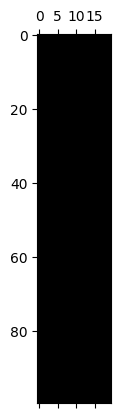

In [17]:
# %%time

batch_size = 100

train_loader, test_loader = get_train_test_dataloaders('..', 'USPS', 
                                                       batch_size=batch_size, 
                                                       drop_last=False,
                                                       num_workers=4)
for x, _ in train_loader:
    x = x.to(device)
    break

relu = nn.ReLU()

line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5

# Quadratic Penalty multiplier 
mu = 1.0

loss_function = torch.nn.MSELoss()
loss_hist = []

# creating model
model = AE_Tanh(bias=False).to(device)
loss = eval_loss(model, test_loader, loss_function, device=device)
loss_hist.append(loss)
print(f'Random-initialized model loss: {loss}')

WEIGHTS = [
    model.encoder[0].weight.detach(),
    model.encoder[2].weight.detach(),
    model.encoder[4].weight.detach(),
    model.decoder[0].weight.detach(),
    model.decoder[2].weight.detach(),
    model.decoder[4].weight.detach(),
]

# all output shapes
h_k = [0]
for W in WEIGHTS:
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:-1]
print(h_k)

# # registering hooks to cache activations
# CACHE_RELUS = {}

# def cache_relu_hook(idx, module, input, output):
#     CACHE_RELUS[idx] = output.detach().cpu()

# i = 0 
# for m in model.modules():
#     if isinstance(m, nn.ReLU):
#         handle = m.register_forward_hook(partial(cache_relu_hook, i))
#         i += 1
        
# # caching activations
# with torch.no_grad():
#     for x, _ in train_loader:
#         x = x.to(device)
#         _ = model(x)
#         x = x.detach().cpu()
        
# # Removing Hooks
# for m in model.modules():
#     if isinstance(m, nn.ReLU):
#         m._forward_hooks = OrderedDict()

n_samples = train_loader.batch_size
# init z_n randomly
CACHE_RELUS = {}
for i, w in enumerate(WEIGHTS[:-1]):
    # CACHE_RELUS[i] = bk.random.uniform(-0.5, 0.5, size=(n_samples, w.shape[0]))
    CACHE_RELUS[i] = torch.rand((n_samples, w.shape[0]), device=device) - 0.5 
        
def _get_n_sample_relus(n_sample, cache):
    n_sample_relus = torch.zeros(h_k[-1], device=device)
    start = 0
    for layer_idx in range(len(h_k)):
        n_sample_relus[start:h_k[layer_idx]] = cache[layer_idx][n_sample]
        start = h_k[layer_idx]
    return n_sample_relus

        
with torch.no_grad():
    for epoch in range(10):
            
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(WEIGHTS))):

            for h in range(WEIGHTS[layer_idx].shape[0]):
                for it in range(3):
                    w_h = WEIGHTS[layer_idx][h]
                    new_w_h = w_step(w_h, layer_idx, h, n_samples, x, CACHE_RELUS)
                    # rel_diff = torch.linalg.norm(new_w_h-w_h) / torch.linalg.norm(w_h)
                    # print(f'layer_idx {layer_idx}, h: {h}, it: {it}, REL_DIFF: {rel_diff}')
                    WEIGHTS[layer_idx][h] = new_w_h
                    
        # Checking Norm Difference
        for layer_idx in range(len(WEIGHTS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm (%): {bk.linalg.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx]) / bk.linalg.norm(WEIGHTS_COPY[layer_idx])}')
        
        # Loading weights back to model to compute eval loss
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # # recalculating activations after weights update
        # for x, _ in train_loader:
        #     x = x.to(device)
        #     _ = model(x)
        #     x = x.cpu()
    
        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
        
        # process for each sample
        for n_sample in tqdm(range(n_samples)):
            for it in range(1):
                z_n = _get_n_sample_relus(n_sample, CACHE_RELUS)
                J, new_z_n = z_step(z_n, n_sample, mu, h_k, x[n_sample], WEIGHTS)
                start = 0
                for layer_idx in range(len(h_k)):
                    CACHE_RELUS[layer_idx][n_sample] = new_z_n[start:h_k[layer_idx]]
                    start = h_k[layer_idx]
                    
                # rel_diff = torch.linalg.norm(new_z_n - z_n) / torch.linalg.norm(z_n)

        # Computing Relus Norm Difference
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm (%): '
                  f'{bk.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx]) / bk.linalg.norm(CACHE_RELUS_COPY[layer_idx])}')
            
        # Updating Quandratic Penalty Multiplier
        mu *= 1.5
        
        if epoch > 0 and epoch % 2 == 0: 
            with torch.no_grad():
                y = model(x[:16].cuda())
            plot_progress(x[:16], y)